In [1]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment2/'
FOLDERNAME = "cs231n/assignment2/"
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/cs231n/assignment2/cs231n/datasets
/content/drive/My Drive/cs231n/assignment2


# Multi-Layer Fully Connected Network
In this exercise, you will implement a fully connected network with an arbitrary number of hidden layers.

Read through the `FullyConnectedNet` class in the file `cs231n/classifiers/fc_net.py`.

Implement the network initialization, forward pass, and backward pass. Throughout this assignment, you will be implementing layers in `cs231n/layers.py`. You can re-use your implementations for `affine_forward`, `affine_backward`, `relu_forward`, `relu_backward`, and `softmax_loss` from Assignment 1. For right now, don't worry about implementing dropout or batch/layer normalization yet, as you will add those features later.


In [2]:
# Setup cell.
import time
import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifiers.fc_net import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.solver import Solver

%matplotlib inline
plt.rcParams["figure.figsize"] = (10.0, 8.0)  # Set default size of plots.
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gray"

%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """Returns relative error."""
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

=========== You can safely ignore the message below if you are NOT working on ConvolutionalNetworks.ipynb ===========
	You will need to compile a Cython extension for a portion of this assignment.
	The instructions to do this will be given in a section of the notebook below.


In [3]:
# Load the (preprocessed) CIFAR-10 data.
data = get_CIFAR10_data()
for k, v in list(data.items()):
    print(f"{k}: {v.shape}")

X_train: (49000, 3, 32, 32)
y_train: (49000,)
X_val: (1000, 3, 32, 32)
y_val: (1000,)
X_test: (1000, 3, 32, 32)
y_test: (1000,)


## Initial Loss and Gradient Check

As a sanity check, run the following to check the initial loss and to gradient check the network both with and without regularization. This is a good way to see if the initial losses seem reasonable.

For gradient checking, you should expect to see errors around 1e-7 or less.

In [4]:
np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for reg in [0, 3.14]:
    print("Running check with reg = ", reg)
    model = FullyConnectedNet(
        [H1, H2],
        input_dim=D,
        num_classes=C,
        reg=reg,
        weight_scale=5e-2,
        dtype=np.float64
    )

    loss, grads = model.loss(X, y)
    print("Initial loss: ", loss)

    # Most of the errors should be on the order of e-7 or smaller.
    # NOTE: It is fine however to see an error for W2 on the order of e-5
    # for the check when reg = 0.0
    for name in sorted(grads):
        f = lambda _: model.loss(X, y)[0]
        grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
        print(f"{name} relative error: {rel_error(grad_num, grads[name])}")

Running check with reg =  0
Initial loss:  2.300479089768492
W1 relative error: 1.0252674471656573e-07
W2 relative error: 2.2120479295080622e-05
W3 relative error: 4.5623278736665505e-07
b1 relative error: 4.6600944653202505e-09
b2 relative error: 2.085654276112763e-09
b3 relative error: 1.689724888469736e-10
Running check with reg =  3.14
Initial loss:  2.3016482157750753
W1 relative error: 3.4418116464042434e-07
W2 relative error: 5.01447553417466e-06
W3 relative error: 1.3981157835519536e-07
b1 relative error: 1.4752427965311745e-08
b2 relative error: 9.483491731270727e-10
b3 relative error: 1.2769370279768773e-10


As another sanity check, make sure your network can overfit on a small dataset of 50 images. First, we will try a three-layer network with 100 units in each hidden layer. In the following cell, tweak the **learning rate** and **weight initialization scale** to overfit and achieve 100% training accuracy within 20 epochs.

(Iteration 1 / 40) loss: 2.363364
(Epoch 0 / 20) train acc: 0.180000; val_acc: 0.108000
(Epoch 1 / 20) train acc: 0.320000; val_acc: 0.127000
(Epoch 2 / 20) train acc: 0.440000; val_acc: 0.172000
(Epoch 3 / 20) train acc: 0.500000; val_acc: 0.184000
(Epoch 4 / 20) train acc: 0.540000; val_acc: 0.181000
(Epoch 5 / 20) train acc: 0.740000; val_acc: 0.190000
(Iteration 11 / 40) loss: 0.839976
(Epoch 6 / 20) train acc: 0.740000; val_acc: 0.187000
(Epoch 7 / 20) train acc: 0.740000; val_acc: 0.183000
(Epoch 8 / 20) train acc: 0.820000; val_acc: 0.177000
(Epoch 9 / 20) train acc: 0.860000; val_acc: 0.200000
(Epoch 10 / 20) train acc: 0.920000; val_acc: 0.191000
(Iteration 21 / 40) loss: 0.337174
(Epoch 11 / 20) train acc: 0.960000; val_acc: 0.189000
(Epoch 12 / 20) train acc: 0.940000; val_acc: 0.180000
(Epoch 13 / 20) train acc: 1.000000; val_acc: 0.199000
(Epoch 14 / 20) train acc: 1.000000; val_acc: 0.199000
(Epoch 15 / 20) train acc: 1.000000; val_acc: 0.195000
(Iteration 31 / 40) loss: 

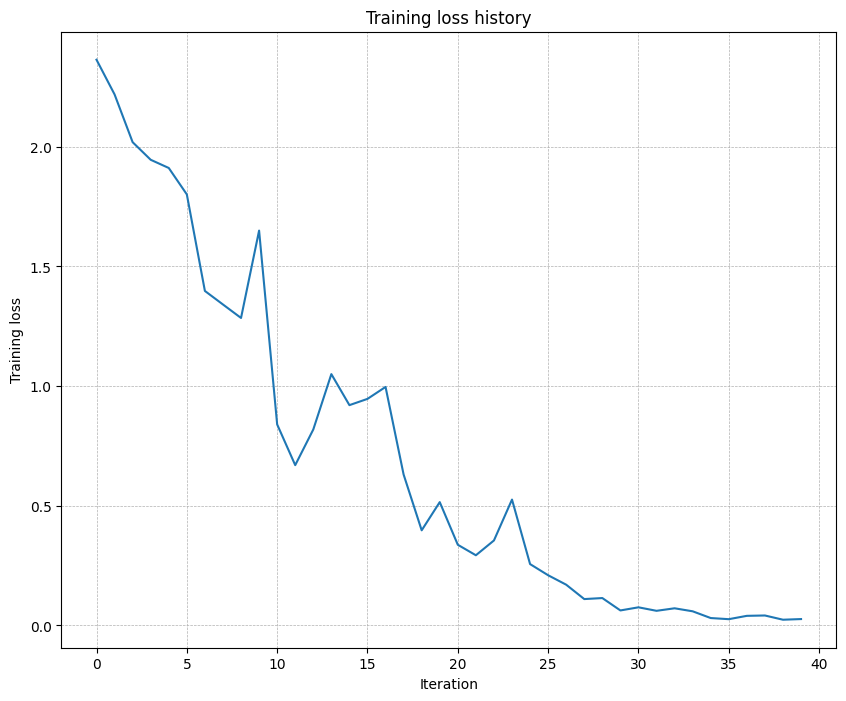

In [5]:
# TODO: Use a three-layer Net to overfit 50 training examples by
# tweaking just the learning rate and initialization scale.

num_train = 50
small_data = {
  "X_train": data["X_train"][:num_train],
  "y_train": data["y_train"][:num_train],
  "X_val": data["X_val"],
  "y_val": data["y_val"],
}

weight_scale = 1e-2   # Experiment with this!
learning_rate = 1e-2  # Experiment with this!
model = FullyConnectedNet(
    [100, 100],
    weight_scale=weight_scale,
    dtype=np.float64
)
solver = Solver(
    model,
    small_data,
    print_every=10,
    num_epochs=20,
    batch_size=25,
    update_rule="sgd",
    optim_config={"learning_rate": learning_rate},
)
solver.train()

plt.plot(solver.loss_history)
plt.title("Training loss history")
plt.xlabel("Iteration")
plt.ylabel("Training loss")
plt.grid(linestyle='--', linewidth=0.5)
plt.show()

Now, try to use a five-layer network with 100 units on each layer to overfit on 50 training examples. Again, you will have to adjust the learning rate and weight initialization scale, but you should be able to achieve 100% training accuracy within 20 epochs.

In [6]:
# TODO: Use a five-layer Net to overfit 50 training examples by
# tweaking just the learning rate and initialization scale.

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

# 찾기힘들어서 자동서치를 만듦 (Coarse -> Fine)
learning_rates = np.geomspace(1e-2, 5e-2, 5)  # Experiment with this!
weight_scales = np.geomspace(1e-2, 5e-2, 5)   # Experiment with this!

best = [0]

for learning_rate in learning_rates:
  for weight_scale in weight_scales:
    print(f"********** lr={learning_rate:.2e}, ws={weight_scale:.2e} **********")

    model = FullyConnectedNet(
        [100, 100, 100, 100],
        weight_scale=weight_scale,
        dtype=np.float64
    )
    solver = Solver(
        model,
        small_data,
        print_every=10,
        num_epochs=20,
        batch_size=25,
        update_rule='sgd',
        optim_config={'learning_rate': learning_rate},
        verbose=False
    )
    solver.train()

    train_acc = solver.check_accuracy(small_data["X_train"],small_data["y_train"])
    print(train_acc,"\n")
    if train_acc > best[0]:
      best = [train_acc, learning_rate, weight_scale]

print(f"********** The best acc, lr and wr: {best} **********\n")

********** lr=1.00e-02, ws=1.00e-02 **********
0.16 

********** lr=1.00e-02, ws=1.50e-02 **********
0.16 

********** lr=1.00e-02, ws=2.24e-02 **********
0.42 

********** lr=1.00e-02, ws=3.34e-02 **********
1.0 

********** lr=1.00e-02, ws=5.00e-02 **********
1.0 

********** lr=1.50e-02, ws=1.00e-02 **********
0.2 

********** lr=1.50e-02, ws=1.50e-02 **********
0.44 

********** lr=1.50e-02, ws=2.24e-02 **********
0.46 

********** lr=1.50e-02, ws=3.34e-02 **********
1.0 

********** lr=1.50e-02, ws=5.00e-02 **********
0.92 

********** lr=2.24e-02, ws=1.00e-02 **********
0.16 

********** lr=2.24e-02, ws=1.50e-02 **********
0.1 

********** lr=2.24e-02, ws=2.24e-02 **********
0.48 

********** lr=2.24e-02, ws=3.34e-02 **********
0.96 

********** lr=2.24e-02, ws=5.00e-02 **********
1.0 

********** lr=3.34e-02, ws=1.00e-02 **********
0.16 

********** lr=3.34e-02, ws=1.50e-02 **********
0.26 

********** lr=3.34e-02, ws=2.24e-02 **********
0.38 

********** lr=3.34e-02, ws=3.34e-0

/content/drive/My Drive/cs231n/assignment2/cs231n/layers.py:151: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probability)) / N
/content/drive/My Drive/cs231n/assignment2/cs231n/layers.py:30: RuntimeWarning: overflow encountered in matmul
  out = x_stretch @ w + b # N*M
/content/drive/My Drive/cs231n/assignment2/cs231n/layers.py:92: RuntimeWarning: invalid value encountered in multiply
  out = x * (x > 0)


0.16 

********** The best acc, lr and wr: [1.0, 0.01, 0.033437015248821096] **********



(Iteration 1 / 40) loss: 3.614415
(Epoch 0 / 20) train acc: 0.140000; val_acc: 0.105000
(Epoch 1 / 20) train acc: 0.240000; val_acc: 0.095000
(Epoch 2 / 20) train acc: 0.600000; val_acc: 0.119000
(Epoch 3 / 20) train acc: 0.720000; val_acc: 0.135000
(Epoch 4 / 20) train acc: 0.900000; val_acc: 0.134000
(Epoch 5 / 20) train acc: 0.860000; val_acc: 0.140000
(Iteration 11 / 40) loss: 0.530093
(Epoch 6 / 20) train acc: 0.960000; val_acc: 0.151000
(Epoch 7 / 20) train acc: 0.960000; val_acc: 0.146000
(Epoch 8 / 20) train acc: 1.000000; val_acc: 0.167000
(Epoch 9 / 20) train acc: 1.000000; val_acc: 0.158000
(Epoch 10 / 20) train acc: 1.000000; val_acc: 0.147000
(Iteration 21 / 40) loss: 0.120538
(Epoch 11 / 20) train acc: 1.000000; val_acc: 0.157000
(Epoch 12 / 20) train acc: 1.000000; val_acc: 0.161000
(Epoch 13 / 20) train acc: 1.000000; val_acc: 0.160000
(Epoch 14 / 20) train acc: 1.000000; val_acc: 0.159000
(Epoch 15 / 20) train acc: 1.000000; val_acc: 0.158000
(Iteration 31 / 40) loss: 

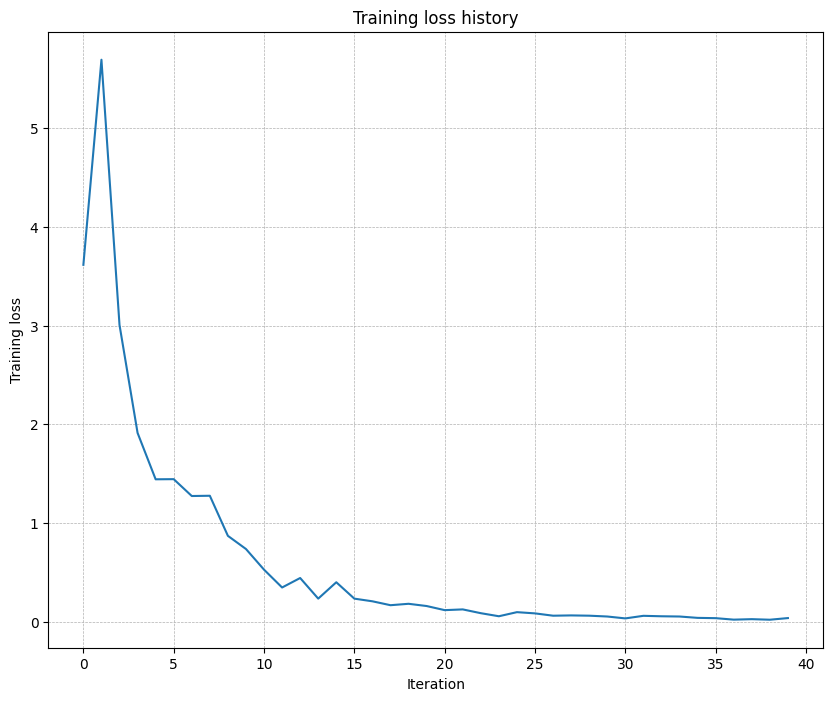

In [7]:
# TODO: Use a five-layer Net to overfit 50 training examples by
# tweaking just the learning rate and initialization scale.

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}


learning_rate = 1e-02  # Experiment with this!
weight_scale = 5e-02   # Experiment with this!

model = FullyConnectedNet(
    [100, 100, 100, 100],
    weight_scale=weight_scale,
    dtype=np.float64
)
solver = Solver(
    model,
    small_data,
    print_every=10,
    num_epochs=20,
    batch_size=25,
    update_rule='sgd',
    optim_config={'learning_rate': learning_rate},
)
solver.train()

train_acc = solver.check_accuracy(small_data["X_train"],small_data["y_train"])
if train_acc > best[0]:
  best = [train_acc, learning_rate, weight_scale]

plt.plot(solver.loss_history)
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.grid(linestyle='--', linewidth=0.5)
plt.show()

## Inline Question 1:
Did you notice anything about the comparative difficulty of training the three-layer network vs. training the five-layer network? In particular, based on your experience, which network seemed more sensitive to the initialization scale? Why do you think that is the case?

## Answer:
5-layer 네트워크가 3-layer 네트워크에 비해 Initialization scale에 훨씬 민감함을 위의 과정에서 알게되었다.  
<br/>
**이유:**  
W 파라미터의 작은값이 레이어를 거듭할 수록 점점 작아져, 0에 수렴하기때문에 깊은 네트워크 일수록 쉽게 죽어버림.  

너무 작으면 update가 멈추거나, 너무 크면 터져버리는(explode) 현상을 볼 수 있는데, 그 사이의 적절한 weight initialization scale 구간이 5-layer의 경우 훨씬 좁은 영역인 것으로 보인다.


# Update rules
So far we have used vanilla stochastic gradient descent (SGD) as our update rule. More sophisticated update rules can make it easier to train deep networks. We will implement a few of the most commonly used update rules and compare them to vanilla SGD.

## SGD+Momentum
Stochastic gradient descent with momentum is a widely used update rule that tends to make deep networks converge faster than vanilla stochastic gradient descent. See the Momentum Update section at http://cs231n.github.io/neural-networks-3/#sgd for more information.

Open the file `cs231n/optim.py` and read the documentation at the top of the file to make sure you understand the API. Implement the SGD+momentum update rule in the function `sgd_momentum` and run the following to check your implementation. You should see errors less than e-8.

In [8]:
from cs231n.optim import sgd_momentum

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
v = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {"learning_rate": 1e-3, "velocity": v}
next_w, _ = sgd_momentum(w, dw, config=config)

expected_next_w = np.asarray([
  [ 0.1406,      0.20738947,  0.27417895,  0.34096842,  0.40775789],
  [ 0.47454737,  0.54133684,  0.60812632,  0.67491579,  0.74170526],
  [ 0.80849474,  0.87528421,  0.94207368,  1.00886316,  1.07565263],
  [ 1.14244211,  1.20923158,  1.27602105,  1.34281053,  1.4096    ]])
expected_velocity = np.asarray([
  [ 0.5406,      0.55475789,  0.56891579, 0.58307368,  0.59723158],
  [ 0.61138947,  0.62554737,  0.63970526,  0.65386316,  0.66802105],
  [ 0.68217895,  0.69633684,  0.71049474,  0.72465263,  0.73881053],
  [ 0.75296842,  0.76712632,  0.78128421,  0.79544211,  0.8096    ]])

# Should see relative errors around e-8 or less
print("next_w error: ", rel_error(next_w, expected_next_w))
print("velocity error: ", rel_error(expected_velocity, config["velocity"]))

next_w error:  8.882347033505819e-09
velocity error:  4.269287743278663e-09


Once you have done so, run the following to train a six-layer network with both SGD and SGD+momentum. You should see the SGD+momentum update rule converge faster.

Running with  sgd
(Iteration 1 / 200) loss: 2.591328
(Epoch 0 / 5) train acc: 0.119000; val_acc: 0.110000
(Iteration 11 / 200) loss: 2.321781
(Iteration 21 / 200) loss: 2.182919
(Iteration 31 / 200) loss: 2.152405
(Epoch 1 / 5) train acc: 0.238000; val_acc: 0.213000
(Iteration 41 / 200) loss: 2.063650
(Iteration 51 / 200) loss: 2.058112
(Iteration 61 / 200) loss: 2.094944
(Iteration 71 / 200) loss: 1.980324
(Epoch 2 / 5) train acc: 0.286000; val_acc: 0.247000
(Iteration 81 / 200) loss: 1.981879
(Iteration 91 / 200) loss: 2.064661
(Iteration 101 / 200) loss: 1.911797
(Iteration 111 / 200) loss: 1.956370
(Epoch 3 / 5) train acc: 0.328000; val_acc: 0.278000
(Iteration 121 / 200) loss: 1.727139
(Iteration 131 / 200) loss: 1.933335
(Iteration 141 / 200) loss: 1.788988
(Iteration 151 / 200) loss: 1.795344
(Epoch 4 / 5) train acc: 0.325000; val_acc: 0.277000
(Iteration 161 / 200) loss: 1.782133
(Iteration 171 / 200) loss: 1.858232
(Iteration 181 / 200) loss: 1.692365
(Iteration 191 / 200) los

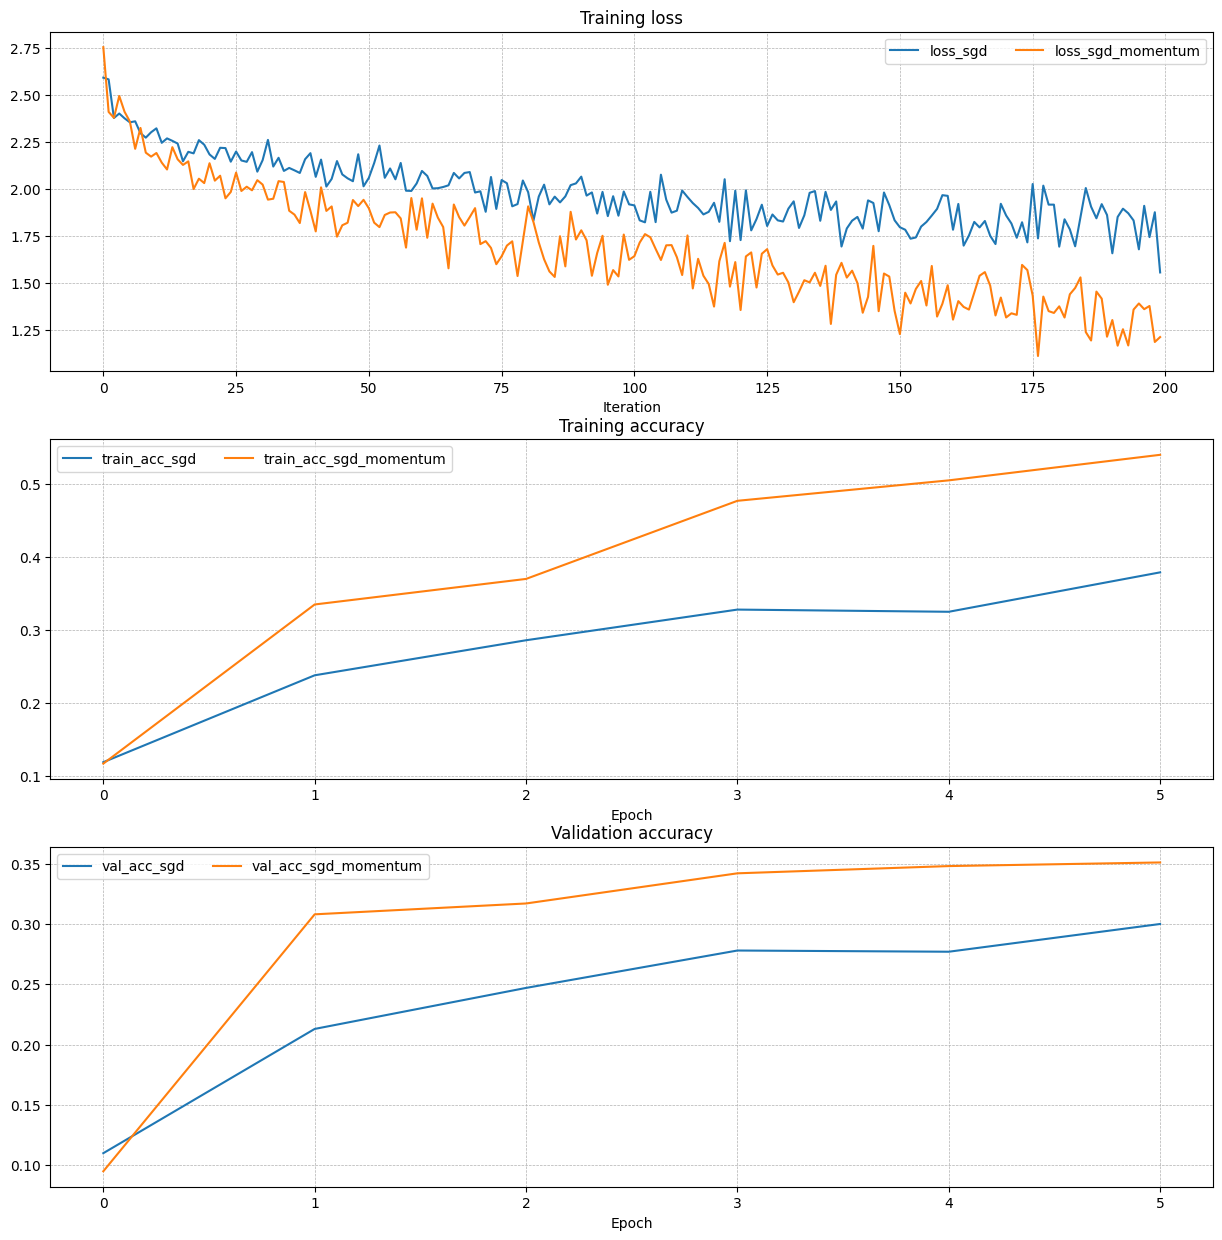

In [9]:
num_train = 4000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}

for update_rule in ['sgd', 'sgd_momentum']:
    print('Running with ', update_rule)
    model = FullyConnectedNet(
        [100, 100, 100, 100, 100],
        weight_scale=5e-2
    )

    solver = Solver(
        model,
        small_data,
        num_epochs=5,
        batch_size=100,
        update_rule=update_rule,
        optim_config={'learning_rate': 5e-3},
        verbose=True,
    )
    solvers[update_rule] = solver
    solver.train()

fig, axes = plt.subplots(3, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')

for update_rule, solver in solvers.items():
    axes[0].plot(solver.loss_history, label=f"loss_{update_rule}")
    axes[1].plot(solver.train_acc_history, label=f"train_acc_{update_rule}")
    axes[2].plot(solver.val_acc_history, label=f"val_acc_{update_rule}")

for ax in axes:
    ax.legend(loc="best", ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.show()

## RMSProp and Adam
RMSProp [1] and Adam [2] are update rules that set per-parameter learning rates by using a running average of the second moments of gradients.

In the file `cs231n/optim.py`, implement the RMSProp update rule in the `rmsprop` function and implement the Adam update rule in the `adam` function, and check your implementations using the tests below.

**NOTE:** Please implement the _complete_ Adam update rule (with the bias correction mechanism), not the first simplified version mentioned in the course notes.

[1] Tijmen Tieleman and Geoffrey Hinton. "Lecture 6.5-rmsprop: Divide the gradient by a running average of its recent magnitude." COURSERA: Neural Networks for Machine Learning 4 (2012).

[2] Diederik Kingma and Jimmy Ba, "Adam: A Method for Stochastic Optimization", ICLR 2015.

In [10]:
# Test RMSProp implementation
from cs231n.optim import rmsprop

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
cache = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'cache': cache}
next_w, _ = rmsprop(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.39223849, -0.34037513, -0.28849239, -0.23659121, -0.18467247],
  [-0.132737,   -0.08078555, -0.02881884,  0.02316247,  0.07515774],
  [ 0.12716641,  0.17918792,  0.23122175,  0.28326742,  0.33532447],
  [ 0.38739248,  0.43947102,  0.49155973,  0.54365823,  0.59576619]])
expected_cache = np.asarray([
  [ 0.5976,      0.6126277,   0.6277108,   0.64284931,  0.65804321],
  [ 0.67329252,  0.68859723,  0.70395734,  0.71937285,  0.73484377],
  [ 0.75037008,  0.7659518,   0.78158892,  0.79728144,  0.81302936],
  [ 0.82883269,  0.84469141,  0.86060554,  0.87657507,  0.8926    ]])

# You should see relative errors around e-7 or less
print('next_w error: ', rel_error(expected_next_w, next_w))
print('cache error: ', rel_error(expected_cache, config['cache']))

next_w error:  9.524687511038133e-08
cache error:  2.6477955807156126e-09


In [11]:
# Test Adam implementation
from cs231n.optim import adam

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
m = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)
v = np.linspace(0.7, 0.5, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'm': m, 'v': v, 't': 5}
next_w, _ = adam(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.40094747, -0.34836187, -0.29577703, -0.24319299, -0.19060977],
  [-0.1380274,  -0.08544591, -0.03286534,  0.01971428,  0.0722929],
  [ 0.1248705,   0.17744702,  0.23002243,  0.28259667,  0.33516969],
  [ 0.38774145,  0.44031188,  0.49288093,  0.54544852,  0.59801459]])
expected_v = np.asarray([
  [ 0.69966,     0.68908382,  0.67851319,  0.66794809,  0.65738853,],
  [ 0.64683452,  0.63628604,  0.6257431,   0.61520571,  0.60467385,],
  [ 0.59414753,  0.58362676,  0.57311152,  0.56260183,  0.55209767,],
  [ 0.54159906,  0.53110598,  0.52061845,  0.51013645,  0.49966,   ]])
expected_m = np.asarray([
  [ 0.48,        0.49947368,  0.51894737,  0.53842105,  0.55789474],
  [ 0.57736842,  0.59684211,  0.61631579,  0.63578947,  0.65526316],
  [ 0.67473684,  0.69421053,  0.71368421,  0.73315789,  0.75263158],
  [ 0.77210526,  0.79157895,  0.81105263,  0.83052632,  0.85      ]])

# You should see relative errors around e-7 or less
print('next_w error: ', rel_error(expected_next_w, next_w))
print('v error: ', rel_error(expected_v, config['v']))
print('m error: ', rel_error(expected_m, config['m']))

next_w error:  1.1395691798535431e-07
v error:  4.208314038113071e-09
m error:  4.214963193114416e-09


Once you have debugged your RMSProp and Adam implementations, run the following to train a pair of deep networks using these new update rules:

Running with  adam
(Iteration 1 / 200) loss: 2.505306
(Epoch 0 / 5) train acc: 0.173000; val_acc: 0.155000
(Iteration 11 / 200) loss: 2.065886
(Iteration 21 / 200) loss: 1.935889
(Iteration 31 / 200) loss: 2.051765
(Epoch 1 / 5) train acc: 0.354000; val_acc: 0.310000
(Iteration 41 / 200) loss: 1.804616
(Iteration 51 / 200) loss: 1.681768
(Iteration 61 / 200) loss: 1.664596
(Iteration 71 / 200) loss: 1.505573
(Epoch 2 / 5) train acc: 0.443000; val_acc: 0.302000
(Iteration 81 / 200) loss: 1.890140
(Iteration 91 / 200) loss: 1.782995
(Iteration 101 / 200) loss: 1.635086
(Iteration 111 / 200) loss: 1.371980
(Epoch 3 / 5) train acc: 0.517000; val_acc: 0.353000
(Iteration 121 / 200) loss: 1.445558
(Iteration 131 / 200) loss: 1.570062
(Iteration 141 / 200) loss: 1.356892
(Iteration 151 / 200) loss: 1.260512
(Epoch 4 / 5) train acc: 0.523000; val_acc: 0.333000
(Iteration 161 / 200) loss: 1.562391
(Iteration 171 / 200) loss: 1.213435
(Iteration 181 / 200) loss: 1.176863
(Iteration 191 / 200) lo

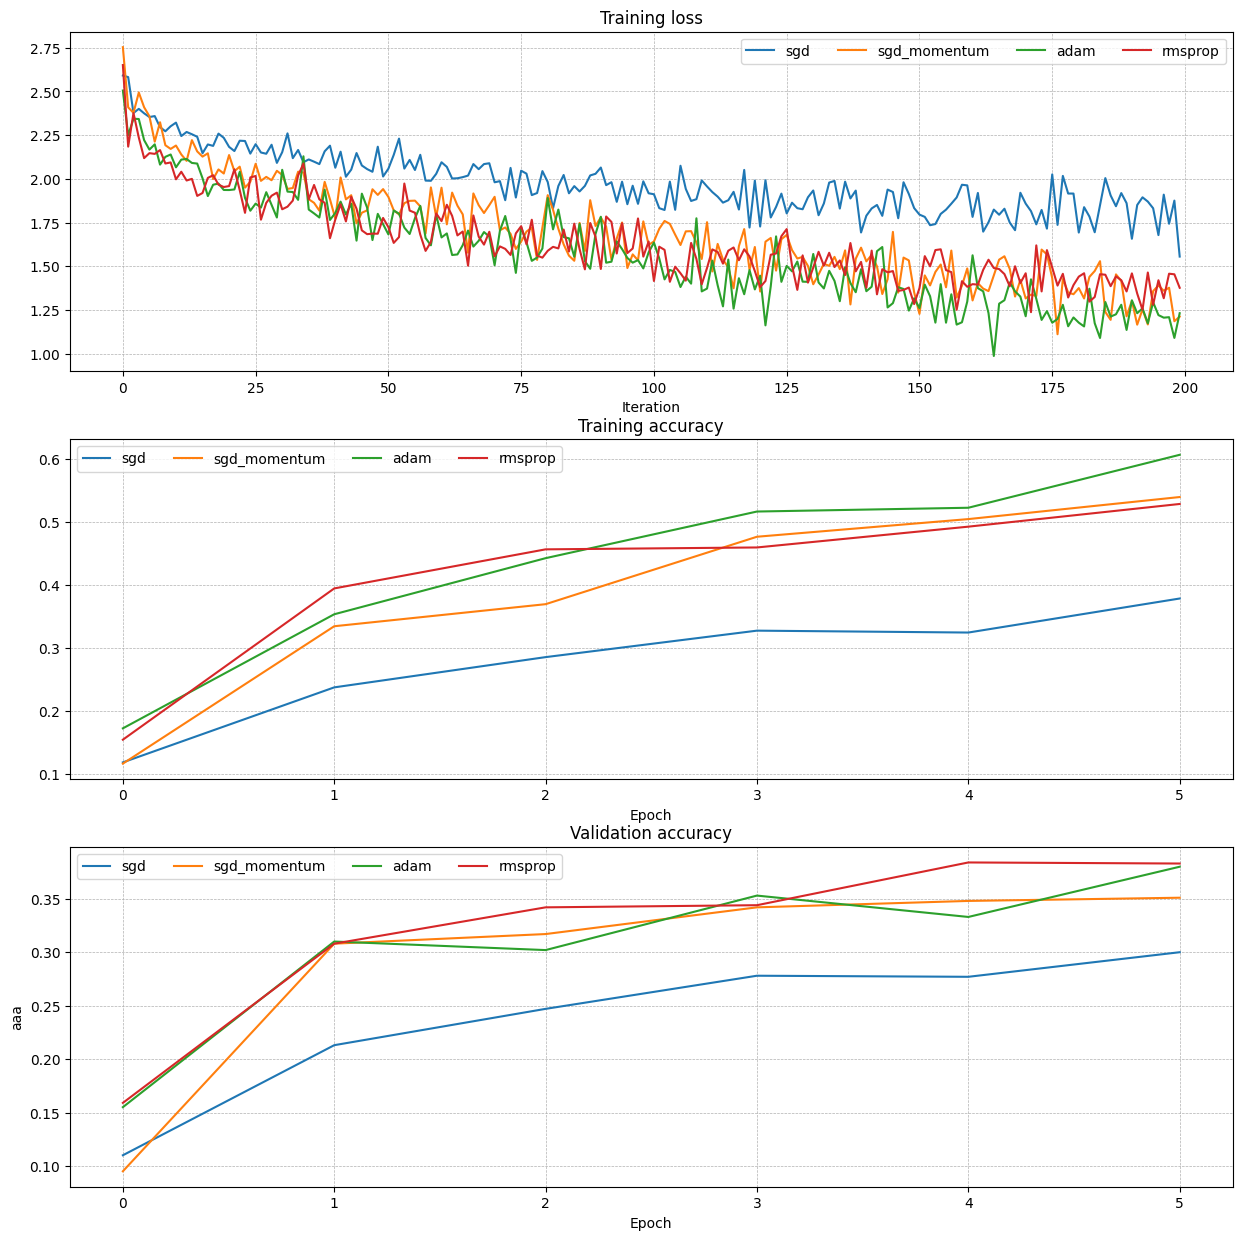

In [12]:
learning_rates = {'rmsprop': 1e-4, 'adam': 1e-3}
for update_rule in ['adam', 'rmsprop']:
    print('Running with ', update_rule)
    model = FullyConnectedNet(
        [100, 100, 100, 100, 100],
        weight_scale=5e-2
    )
    solver = Solver(
        model,
        small_data,
        num_epochs=5,
        batch_size=100,
        update_rule=update_rule,
        optim_config={'learning_rate': learning_rates[update_rule]},
        verbose=True
    )
    solvers[update_rule] = solver
    solver.train()
    print()

fig, axes = plt.subplots(3, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('aaa')

for update_rule, solver in solvers.items():
    axes[0].plot(solver.loss_history, label=f"{update_rule}")
    axes[1].plot(solver.train_acc_history, label=f"{update_rule}")
    axes[2].plot(solver.val_acc_history, label=f"{update_rule}")

for ax in axes:
    ax.legend(loc='best', ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.show()

## Inline Question 2:

AdaGrad, like Adam, is a per-parameter optimization method that uses the following update rule:

```
cache += dw**2
w += - learning_rate * dw / (np.sqrt(cache) + eps)
```

John notices that when he was training a network with AdaGrad that the updates became very small, and that his network was learning slowly. Using your knowledge of the AdaGrad update rule, why do you think the updates would become very small? Would Adam have the same issue?


## Answer:
AdaGrad의 다음과 같은 알고리즘에서,
```
grad_squared = 0  
while True:  
  dx = compute_gradient(x)  
  grad_squared += dx * dx  
  x -= learning_rate * dx / (np.sqrt(grad_squared) + 1e-7)  
```
$\sqrt{grad\_squared}$ 의 값이 계속 누적되어 커지는데, 따라서 그 값으로 나눠지는 업데이트 속도는 계속해서 느려진다.  
<br/>
반면에 Adam 에서는 beta값을 이용해 first moment와 second moment의 값이 누적되지 않도록 해주기 때문에 이슈가 발생하지 않는다.  
```
first_moment = beta1 * first_moment + (1- beta1) * dx
second_moment = beta2 * second_moment * (1 - beta2) * dx * dx
```

# Train a Good Model!
Train the best fully connected model that you can on CIFAR-10, storing your best model in the `best_model` variable. We require you to get at least 50% accuracy on the validation set using a fully connected network.

If you are careful it should be possible to get accuracies above 55%, but we don't require it for this part and won't assign extra credit for doing so. Later in the assignment we will ask you to train the best convolutional network that you can on CIFAR-10, and we would prefer that you spend your effort working on convolutional networks rather than fully connected networks.

**Note:** You might find it useful to complete the `BatchNormalization.ipynb` and `Dropout.ipynb` notebooks before completing this part, since those techniques can help you train powerful models.

In [13]:
best_model = None

################################################################################
# TODO: Train the best FullyConnectedNet that you can on CIFAR-10. You might   #
# find batch/layer normalization and dropout useful. Store your best model in  #
# the best_model variable.                                                     #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

from math import ceil
from random import choice,uniform,randint,randrange
from cs231n import optim

#하이퍼파라미터 자동 random 서치
def search_hyperparameters(num_search=30, update_rule=None, range_layers = (2,8),
                           range_hidden=(5,9), normalization=None, range_p=(0,1),
                           range_lr=(-6,-2), range_epochs=(2,2), range_batch=(100,501), print_every=500):
  best_solver = None
  best_model = None

  for t_search in range(num_search):
    if update_rule is None:
      current_update_rule = choice([attr for attr in dir(optim) if callable(getattr(optim, attr))])
    else:
      current_update_rule = update_rule

    num_layers = randint(*range_layers)
    hidden_dim = 2**randint(*range_hidden) # 2의 배수 (32, 64, ... , 512)
    hidden_dims = [hidden_dim for _ in range(num_layers-1)]

    if normalization is None:
      current_norm = choice(["batchnorm", "layernorm"])
    else:
      current_norm = normalization
    p = uniform(*range_p)

    lr = 10**uniform(*range_lr)
    num_epochs = randint(*range_epochs)
    batch_size = randrange(*range_batch, 100)

    model = FullyConnectedNet(hidden_dims, dropout_keep_ratio=p, normalization=current_norm)
    solver = Solver(model, data,
                    update_rule=current_update_rule,
                    optim_config={"learning_rate":lr},
                    num_epochs=num_epochs,
                    batch_size=batch_size,
                    print_every=print_every)
    print(f"SEARCH {t_search+1:3} :\tupdate_rule={solver.update_rule.__name__}, "
          f"num_layers={model.num_layers}, hidden_dim={model.hidden_dims[0]}, "
          f"norm={model.normalization},\n\t\tp={model.dropout_keep_ratio:.2f}, "
          f"lr={solver.optim_config['learning_rate']:.2e}, "
          f"num_epochs={solver.num_epochs}, batch_size={solver.batch_size}")
    solver.train()

    if best_solver is None or best_solver.best_val_acc < solver.best_val_acc:
      best_model = model
      best_solver = solver
    print("\n************************************************************\n")

  print(f"The best model's validation accuracy is {best_solver.best_val_acc} with the following hyperparameters:")
  print(f"\tupdate_rule={best_solver.update_rule.__name__}, "
        f"num_layers={best_model.num_layers}, hidden_dim={best_model.hidden_dims[0]}, "
        f"norm={best_model.normalization},\n\tp={best_model.dropout_keep_ratio:.2f}, "
        f"lr={best_solver.optim_config['learning_rate']:.2e}, "
        f"num_epochs={best_solver.num_epochs}, batch_size={best_solver.batch_size}")

  return best_solver, best_model

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

In [14]:
# Coarse Search
best_solver, best_model = search_hyperparameters()

SEARCH   1 :	update_rule=sgd, num_layers=5, hidden_dim=64, norm=batchnorm,
		p=0.28, lr=1.45e-03, num_epochs=2, batch_size=200
(Iteration 1 / 490) loss: 2.305639
(Epoch 0 / 2) train acc: 0.083000; val_acc: 0.098000
(Epoch 1 / 2) train acc: 0.088000; val_acc: 0.108000
(Epoch 2 / 2) train acc: 0.124000; val_acc: 0.118000

************************************************************

SEARCH   2 :	update_rule=sgd, num_layers=5, hidden_dim=32, norm=layernorm,
		p=0.56, lr=3.55e-06, num_epochs=2, batch_size=200
(Iteration 1 / 490) loss: 2.300588
(Epoch 0 / 2) train acc: 0.127000; val_acc: 0.139000
(Epoch 1 / 2) train acc: 0.103000; val_acc: 0.139000
(Epoch 2 / 2) train acc: 0.132000; val_acc: 0.139000

************************************************************

SEARCH   3 :	update_rule=sgd, num_layers=4, hidden_dim=512, norm=layernorm,
		p=0.26, lr=3.66e-06, num_epochs=2, batch_size=300
(Iteration 1 / 326) loss: 2.336881
(Epoch 0 / 2) train acc: 0.112000; val_acc: 0.107000
(Epoch 1 / 2) tr

In [16]:
# Fine Search
best_solver, best_model = search_hyperparameters(num_search=10, update_rule="adam",
                                                 range_layers = (7,9), range_hidden=(8,10),
                                                 normalization="layernorm", range_p=(0.9,1),
                                                 range_lr=(-3,-2), range_epochs=(5,5),
                                                 range_batch=(300,501))

SEARCH   1 :	update_rule=adam, num_layers=7, hidden_dim=512, norm=layernorm,
		p=0.93, lr=6.92e-03, num_epochs=5, batch_size=400
(Iteration 1 / 610) loss: 2.324901
(Epoch 0 / 5) train acc: 0.135000; val_acc: 0.152000
(Epoch 1 / 5) train acc: 0.169000; val_acc: 0.158000
(Epoch 2 / 5) train acc: 0.233000; val_acc: 0.240000
(Epoch 3 / 5) train acc: 0.344000; val_acc: 0.330000
(Epoch 4 / 5) train acc: 0.409000; val_acc: 0.412000
(Iteration 501 / 610) loss: 1.708871
(Epoch 5 / 5) train acc: 0.479000; val_acc: 0.458000

************************************************************

SEARCH   2 :	update_rule=adam, num_layers=7, hidden_dim=256, norm=layernorm,
		p=0.99, lr=5.16e-03, num_epochs=5, batch_size=300
(Iteration 1 / 815) loss: 2.306102
(Epoch 0 / 5) train acc: 0.102000; val_acc: 0.112000
(Epoch 1 / 5) train acc: 0.247000; val_acc: 0.266000
(Epoch 2 / 5) train acc: 0.360000; val_acc: 0.387000
(Epoch 3 / 5) train acc: 0.430000; val_acc: 0.451000
(Iteration 501 / 815) loss: 1.609501
(Epoc

# Test Your Model!
Run your best model on the validation and test sets. You should achieve at least 50% accuracy on the validation set.

In [17]:
y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
print('Validation set accuracy: ', (y_val_pred == data['y_val']).mean())
print('Test set accuracy: ', (y_test_pred == data['y_test']).mean())

Validation set accuracy:  0.516
Test set accuracy:  0.485
